## Import Libraries


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/HAPT Data Set"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/HAPT Data Set


In [ ]:
import numpy as np
import pandas as pd
import os

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical

from scipy.stats import mode

## Reading Raw Data

In [ ]:
files = os.listdir('./RawData/')
files.sort()

raw_labels = pd.read_csv('RawData/labels.txt',sep=' ',header=None)
raw_labels['diff'] = raw_labels[4] - raw_labels[3]
intervals = raw_labels['diff']

acc_file = []
gyro_file = []
for file in files:
    if file.startswith('acc'):
        acc_file.append(pd.read_csv('RawData/' + file, sep=' ', header=None))
    elif file.startswith('gyro'):
        gyro_file.append(pd.read_csv('RawData/' + file, sep=' ', header=None))

columns = ['user', 'activity', 'time', 'ax','ay','az', 'gx', 'gy', 'gz', 'interval']
label_dict = {1: "WALKING",
              2: "WALKING_UPSTAIRS",
              3: "WALKING_DOWNSTAIRS",
              4: "SITTING",
              5: "STANDING",
              6: "LAYING",
              7: "STAND_TO_SIT",
              8: "SIT_TO_STAND", 
              9: "SIT_TO_LIE", 
              10: "LIE_TO_SIT",
              11: "STAND_TO_LIE",
              12: "LIE_TO_STAND"}
label_dict_rev = {v: k for k, v in label_dict.items()}
label_list = list(label_dict.values())

data = []
for exper, user, label, start, end, itv in raw_labels.values:
    temp = [user, label_dict[label]]
    for i in range(end-start):
        #print(exper,user,label_dict[label])
        a = acc_file[exper-1].values[start+i-1]
        b = gyro_file[exper-1].values[start+i-1]
        temp.append(start+i-1)
        temp.extend([a[0], a[1], a[2]])
        temp.extend([b[0], b[1], b[2]])
        temp.append(itv)
        data.append(temp)
        temp = [user, label_dict[label]]

data = pd.DataFrame(data = data, columns = columns)

In [ ]:
data

,user,activity,time,ax,ay,az,gx,gy,gz,interval
0,1,STANDING,249,1.020833,-0.125000,0.104167,-0.000916,0.001833,0.002749,982
1,1,STANDING,250,1.020833,-0.125000,0.105556,-0.002749,-0.004276,0.002749,982
2,1,STANDING,251,1.025000,-0.125000,0.101389,-0.000305,-0.002138,0.006109,982
3,1,STANDING,252,1.020833,-0.125000,0.104167,0.012217,0.000916,-0.007330,982
4,1,STANDING,253,1.016667,-0.125000,0.108333,0.011301,-0.001833,-0.006414,982
...,...,...,...,...,...,...,...,...,...,...
814395,30,WALKING_UPSTAIRS,18091,0.987500,-0.495833,-0.197222,1.129184,1.006095,-0.224798,703
814396,30,WALKING_UPSTAIRS,18092,0.950000,-0.443056,-0.187500,1.184773,1.112386,-0.307876,703
814397,30,WALKING_UPSTAIRS,18093,0.880556,-0.390278,-0.156944,1.163698,1.106277,-0.374155,703
814398,30,WALKING_UPSTAIRS,18094,0.834722,-0.358333,-0.098611,1.177137,1.023810,-0.388816,703


## Train Test Split


In [ ]:
subject_id_train = pd.read_csv('Train/subject_id_train.txt',header=None)[0].unique()
subject_id_test = pd.read_csv('Test/subject_id_test.txt',header=None)[0].unique()

In [ ]:
print(subject_id_train)
print(subject_id_test)

[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]
[ 2  4  9 10 12 13 18 20 24]


In [ ]:
import random
random.seed(1)
rand_idx = [random.randrange(len(subject_id_train)) for i in range(3)]
print(rand_idx)

[4, 18, 2]


In [ ]:
rand_idx = [2, 9, 13]
subject_id_val = subject_id_train[rand_idx]

subject_id_train = np.delete(subject_id_train, [rand_idx])

print(subject_id_val)
print(subject_id_train)

[ 5 16 22]
[ 1  3  6  7  8 11 14 15 17 19 21 23 25 26 27 28 29 30]


In [ ]:
train_data = data[data.user.isin(subject_id_train)]
val_data = data[data.user.isin(subject_id_val)]
test_data = data[data.user.isin(subject_id_test)]

## Standardising Values

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ct = ColumnTransformer([
        ('scale', StandardScaler(), ['ax', 'ay', 'az', 'gx', 'gy', 'gz'])
    ], remainder='passthrough')

train_data = ct.fit_transform(train_data)
val_data = ct.transform(val_data)
test_data = ct.transform(test_data)

## Sliding window

In [ ]:
## Reshaping data 

step = 50
window_size = 250
n_features = 6

x_train = []
y_train = []

for user_id in subject_id_train:
  user_data = train_data[train_data[:, 6] == user_id]

  for i in range (0, user_data.shape[0]-window_size, step):
      X0 = user_data[i:i + window_size, 0]
      X1 = user_data[i:i + window_size, 1]
      X2 = user_data[i:i + window_size, 2]
      X3 = user_data[i:i + window_size, 3]
      X4 = user_data[i:i + window_size, 4]
      X5 = user_data[i:i + window_size, 5]
      y = mode(user_data[i: i + 50, 7])[0][0]
      x_train.append([X0, X1, X2, X3, X4, X5])
      y_train.append(y)

In [ ]:
x_train = np.asarray(x_train, dtype= np.float32).reshape(-1, window_size, n_features)
x_train.shape

(9903, 250, 6)

In [ ]:
label_train = pd.get_dummies(y_train).columns.tolist()
label_train

['LAYING',
 'LIE_TO_SIT',
 'LIE_TO_STAND',
 'SITTING',
 'SIT_TO_LIE',
 'SIT_TO_STAND',
 'STANDING',
 'STAND_TO_LIE',
 'STAND_TO_SIT',
 'WALKING',
 'WALKING_DOWNSTAIRS',
 'WALKING_UPSTAIRS']

In [ ]:
y_train = np.asarray(pd.get_dummies(y_train), dtype = np.float32)
y_train.shape

(9903, 12)

In [ ]:
step = 50
window_size = 250
n_features = 6

x_val = []
y_val = []

for user_id in subject_id_val:
  user_data = val_data[val_data[:, 6] == user_id]

  for i in range (0, user_data.shape[0]-window_size, step):
      X0 = user_data[i:i + window_size, 0]
      X1 = user_data[i:i + window_size, 1]
      X2 = user_data[i:i + window_size, 2]
      X3 = user_data[i:i + window_size, 3]
      X4 = user_data[i:i + window_size, 4]
      X5 = user_data[i:i + window_size, 5]
      y = mode(user_data[i: i + 50, 7])[0][0]
      x_val.append([X0, X1, X2, X3, X4, X5])
      y_val.append(y)

In [ ]:
x_val = np.asarray(x_val, dtype= np.float32).reshape(-1, window_size, n_features)
x_val.shape

(1548, 250, 6)

In [ ]:
label_val = pd.get_dummies(y_val).columns.tolist()
label_val

['LAYING',
 'LIE_TO_SIT',
 'LIE_TO_STAND',
 'SITTING',
 'SIT_TO_LIE',
 'SIT_TO_STAND',
 'STANDING',
 'STAND_TO_LIE',
 'STAND_TO_SIT',
 'WALKING',
 'WALKING_DOWNSTAIRS',
 'WALKING_UPSTAIRS']

In [ ]:
y_val = np.asarray(pd.get_dummies(y_val), dtype = np.float32)
y_val.shape

(1548, 12)

In [ ]:
step = 50
window_size = 250
n_features = 6

x_test = []
y_test = []

for user_id in subject_id_test:
  user_data = test_data[test_data[:, 6] == user_id]

  for i in range (0, user_data.shape[0]-window_size, step):
      X0 = user_data[i:i + window_size, 0]
      X1 = user_data[i:i + window_size, 1]
      X2 = user_data[i:i + window_size, 2]
      X3 = user_data[i:i + window_size, 3]
      X4 = user_data[i:i + window_size, 4]
      X5 = user_data[i:i + window_size, 5]
      y = mode(user_data[i: i + 50, 7])[0][0]
      x_test.append([X0, X1, X2, X3, X4, X5])
      y_test.append(y)

In [ ]:
x_test = np.asarray(x_test, dtype= np.float32).reshape(-1, window_size, n_features)
x_test.shape

(4701, 250, 6)

In [ ]:
label_test = pd.get_dummies(y_test).columns.tolist()
label_test

['LAYING',
 'LIE_TO_SIT',
 'LIE_TO_STAND',
 'SITTING',
 'SIT_TO_LIE',
 'SIT_TO_STAND',
 'STANDING',
 'STAND_TO_LIE',
 'STAND_TO_SIT',
 'WALKING',
 'WALKING_DOWNSTAIRS',
 'WALKING_UPSTAIRS']

In [ ]:
y_test = np.asarray(pd.get_dummies(y_test), dtype = np.float32)
y_test.shape

(4701, 12)

In [ ]:
print(x_train)
print(y_train)
print(x_test)
print(y_test)

[[[ 5.3316045e-01  5.3316045e-01  5.4332864e-01  5.3316045e-01
    5.2299225e-01  5.2638167e-01]
  [ 5.2638167e-01  5.2977103e-01  5.2299225e-01  5.3316045e-01
    5.2977103e-01  5.2977103e-01]
  [ 5.3654987e-01  5.2977103e-01  5.2299225e-01  5.2977103e-01
    5.2977103e-01  5.3316045e-01]
  ...
  [ 5.2098714e-02  7.1429163e-02  7.4481338e-02  7.1429163e-02
    7.2446555e-02  5.7185672e-02]
  [ 6.1255239e-02  7.0411772e-02  3.4803052e-02  3.7855227e-02
    2.1576954e-02  2.2594346e-02]
  [ 9.3682501e-03  3.2768264e-02  1.7507385e-02  3.2768264e-02
    4.7011752e-02  3.3785656e-02]]

 [[ 5.3654987e-01  5.2638167e-01  5.1960284e-01  5.3654987e-01
    5.3316045e-01  5.2638167e-01]
  [ 5.3654987e-01  5.3654987e-01  5.2638167e-01  5.2299225e-01
    5.3654987e-01  5.1282406e-01]
  [ 5.1960284e-01  5.3316045e-01  5.3316045e-01  5.3993922e-01
    5.3316045e-01  5.3316045e-01]
  ...
  [ 2.3611737e-02  2.9716089e-02  2.1576954e-02 -8.0566987e-04
    2.1576954e-02  4.2812903e-03]
  [-1.3014374e-0

## Train Model

In [ ]:
## Model Architecture

n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
n_epochs = 50      
batch_size = 64

model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               42800     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dense_8 (Dense)             (None, 12)                1212      
                                                                 
Total params: 64,212
Trainable params: 64,212
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## Model Training
history = model.fit(x_train, y_train, epochs = n_epochs, batch_size = batch_size, validation_data = (x_val, y_val), verbose = 1)

Epoch 1/50
155/155 [==============================] - 38s 231ms/step - loss: 1.6532 - accuracy: 0.3481 - val_loss: 1.2924 - val_accuracy: 0.4063
Epoch 2/50
155/155 [==============================] - 35s 224ms/step - loss: 1.2019 - accuracy: 0.4582 - val_loss: 1.4079 - val_accuracy: 0.3456
Epoch 3/50
155/155 [==============================] - 35s 227ms/step - loss: 1.2837 - accuracy: 0.4340 - val_loss: 1.2199 - val_accuracy: 0.4548
Epoch 4/50
155/155 [==============================] - 36s 236ms/step - loss: 1.0748 - accuracy: 0.5094 - val_loss: 1.1142 - val_accuracy: 0.4981
Epoch 5/50
155/155 [==============================] - 35s 227ms/step - loss: 0.9897 - accuracy: 0.5402 - val_loss: 1.0369 - val_accuracy: 0.5439
Epoch 6/50
155/155 [==============================] - 35s 227ms/step - loss: 0.9403 - accuracy: 0.5663 - val_loss: 1.0058 - val_accuracy: 0.5278
Epoch 7/50
155/155 [==============================] - 37s 239ms/step - loss: 0.8650 - accuracy: 0.6590 - val_loss: 0.8872 - val_ac

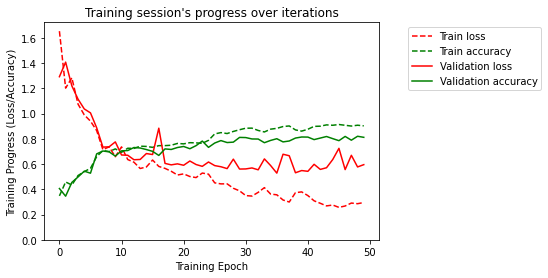

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(bbox_to_anchor=(1.5, 1))
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0) 
plt.show()

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, batch_size = batch_size, verbose = 1)
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)

74/74 [==============================] - 6s 80ms/step - loss: 0.6163 - accuracy: 0.8141
Test Accuracy : 0.8140820860862732
Test Loss : 0.6163398027420044


147/147 [==============================] - 7s 46ms/step


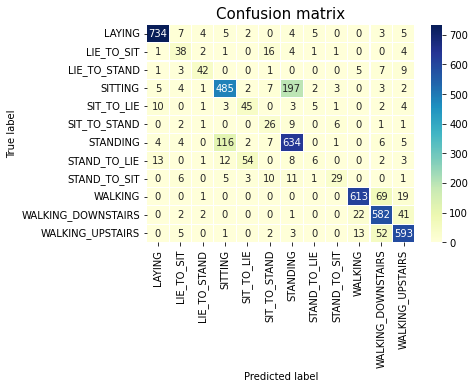

In [ ]:
from sklearn import metrics
import seaborn as sns

predictions = model.predict(x_test)
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
sns.heatmap(confusion_matrix, xticklabels = label_test, yticklabels = label_test, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

The model seems to have difficulty differentiating the two classes sitting and standing. This may be because both classes have very stationary actions. The model also seems to find it difficult predicting sit to lie and stand to lie. Hence, to further improve on the short comings of this model, it would be good to use models that could possibly learn these features, like a CNN-LSTM.